In [12]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt
import plotly.express as px
credit = pd.read_csv('credit_record.csv')  
application = pd.read_csv('application_record.csv') 
credit

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [2]:
len(set(application['ID'])) # ¿cuántos ID únicos en el registro de la aplicación?

438510

In [3]:
len(set(credit['ID'])) # ¿cuántos ID únicos en el registro de crédito?

45985

In [4]:
len(set(application['ID']).intersection(set(credit['ID']))) # ¿cuántos de los IDs comparten dos tablas?

36457

# KPI

In [5]:
grouped = credit.groupby('ID')
### convertir datos de crédito a un formato amplio que cada ID es una fila
pivot_tb = credit.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min() # mes de apertura
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max() # mes final
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'open_month', 'end_month']]
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month']
pivot_tb.reset_index(drop = True, inplace = True)
credit = pd.merge(credit, pivot_tb, on = 'ID', how = 'left')
credit0 = credit.copy()
credit = credit[credit['window'] > 20] # eliminar a los usuarios cuya ventana de observación menos de 20
credit['status'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) # analyze > 60 days past due 
credit['status'] = credit['status'].astype(np.int8) # 1: overdue 0: not
credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month'] # calculate month on book: how many months after opening account
credit.sort_values(by = ['ID','month_on_book'], inplace = True)

##### 
denominator = pivot_tb.groupby(['open_month']).agg({'ID': ['count']}) # count how many users in every month the account was opened
denominator.reset_index(inplace = True)
denominator.columns = ['open_month','sta_sum']

#####
kpi = credit.groupby(['open_month','month_on_book']).agg({'ID': ['count']}) 
kpi.reset_index(inplace = True)
kpi.columns = ['open_month','month_on_book','sta_sum'] 
kpi['due_count'] = np.nan
kpi = kpi[['open_month','month_on_book','due_count']] # delete aggerate column
kpi = pd.merge(kpi, denominator, on = ['open_month'], how = 'left') # join sta_sum colun to kpi table
kpi

,open_month,month_on_book,due_count,sta_sum
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415
...,...,...,...,...
1655,-21,17,NaN,858
1656,-21,18,NaN,858
1657,-21,19,NaN,858
1658,-21,20,NaN,858


In [6]:
for j in range(-60,1): # outer loop: month in which account was opened
    ls = []
    for i in range(0,61): # inner loop time after the credit card was granted
        due = list(credit[(credit['status'] == 1) & (credit['month_on_book'] == i) & (credit['open_month'] == j)]['ID']) # get ID which satisfy the condition
        ls.extend(due) # As time goes, add bad customers
        kpi.loc[(kpi['month_on_book'] == i) & (kpi['open_month'] == j), 'due_count'] = len(set(ls)) # calculate non-duplicate ID numbers using set()
        
kpi['sta_rate']  = kpi['due_count'] / kpi['sta_sum'] # calculate cumulative % of bad customers
kpi        

,open_month,month_on_book,due_count,sta_sum,sta_rate
0,-60,0,0.0,415,0.000000
1,-60,1,0.0,415,0.000000
2,-60,2,0.0,415,0.000000
3,-60,3,0.0,415,0.000000
4,-60,4,0.0,415,0.000000
...,...,...,...,...,...
1655,-21,17,15.0,858,0.017483
1656,-21,18,15.0,858,0.017483
1657,-21,19,15.0,858,0.017483
1658,-21,20,15.0,858,0.017483


Using `pivot` to convert long data to wide data:

In [7]:
kpi_wide = kpi.pivot(index = 'open_month',
                             columns = 'month_on_book',
                             values = 'sta_rate')
kpi_wide

month_on_book,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
open_month,,,,,,,,,,,,,,,,,,,,,
-60,0.00000,0.000000,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,...,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.00000,0.000000,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,...,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.00000,0.000000,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.00000,0.000000,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,...,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55,0.00000,0.000000,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,0.024691,...,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54,0.00000,0.000000,0.000000,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,0.017094,...,0.032051,0.032051,0.032051,0.032051,NaN,NaN,NaN,NaN,NaN,NaN
-53,0.00000,0.002028,0.002028,0.002028,0.004057,0.004057,0.008114,0.010142,0.010142,0.012170,...,0.028398,0.028398,0.028398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-52,0.00000,0.000000,0.007233,0.009042,0.009042,0.009042,0.012658,0.012658,0.014467,0.016275,...,0.023508,0.023508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Esta es una tabla de análisis de kpi. Las filas representan meses de apertura de cuentas, las columnas representan meses después de la apertura de cuentas y los valores son la tasa acumulada de vencimiento. A medida que el mes abierto se cierra a 0, la ventana de observación se acorta, por lo que el campo triangular de la mitad inferior se llena con nan. 

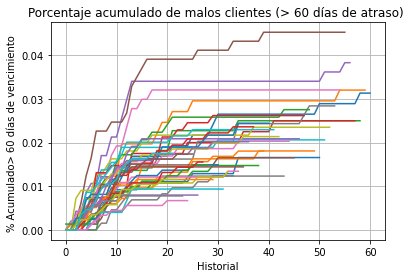

In [8]:
kpi0 = kpi_wide.replace(0,np.nan)
lst = [i for i in range(0,61)]
kpi_wide[lst].T.plot(legend = False, grid = True, title = 'Porcentaje acumulado de malos clientes (> 60 días de atraso) ')
#plt.axvline(30)
#plt.axvline(25)
#plt.axvline(20)
plt.xlabel('Historial')
plt.ylabel('% Acumulado> 60 días de vencimiento ')
plt.show()

KeyError: '[0.17640534957051213, 0.20969881483092312, 0.2688702837881918, 0.24060019571599434, 0.32765032075676853, 0.4068283135805154, 0.4310753506578232, 0.455322387735131, 0.47950418614765683, 0.733326084592802, 0.7472654126345547, 0.9255844297053387, 0.7191475481135152, 0.9550723061868001, 0.5828857236055235, 0.5639012721539632, 0.933217353484832, 0.9670327280634989, 0.7864521039469392, 0.8906599978253779, 0.6548874633032511, 0.9848211373273894, 0.9951723388061324, 0.5018158095030988, 0.5449820593671849, 0.6021311297162119, 0.6713493530499076, 0.3822115907361096, 0.7033597912362727, 0.0867456779384582, 0.11342829183429379, 0.14472110470805696, 0.6392954224203544, 0.00867674241600522, 0.6878112427965641, 0.8119604218766989, 0.8711318908339676, 0.8608024355768186, 0.5231271066652169, 0.9079917364357942, 0.9900837229531368, 0.05762748722409481, 0.7599652060454496, 0.8811351527672067, 0.899662933565293, 0.9613787104490594, 0.3567250190279439, 0.7732956398825704, 0.8497336087854735, 0.2981624442753072, 0.03233663151027509, 0.6211808198325541, 0.8242905295204959, 0.9165814939654235, 0.799304120908992, 0.9479395455039686, 0.9735348483201044, 0.9796455365880178, 0.8374252473632706, 0.9405240839404153] not in index'

# Observar el análisis de la ventana

Debido a dos razones, la cancelación de la cuenta y la cancelación, nuestra observación de las cuentas se truncará. La ventana de observación es un parámetro importante a considerar. Si la ventana de observación es demasiado corta, el comportamiento de los usuarios no se mostrará por completo, lo que traerá un ruido innecesario a nuestros datos.

Para observar cuántas cuentas aumentan a medida que se extiende la ventana de observación, raelicemos la siguiente grafica.  

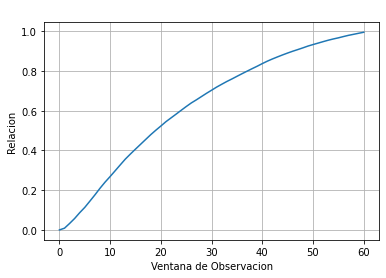

In [9]:
lst = []
for i in range(0,61):
    ratio = len(pivot_tb[pivot_tb['window'] < i]) / len(set(pivot_tb['ID']))
    lst.append(ratio)
    
pd.Series(lst).plot(legend = False, grid = True, title = ' ')
plt.xlabel('Ventana de Observacion')
plt.ylabel('Relacion')
plt.show()

Pudimos ver que una ventana de observación de 60 meses cubre a todos los aplicadores, mientras que la ventana de 20 meses contiene registros de aproximadamente el 52%. 

In [10]:
def calculate_observe(credit, command):
    '''calculate observe window
    '''
    id_sum = len(set(pivot_tb['ID']))
    credit['status'] = 0
    exec(command)
    #credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month']
    minagg = credit[credit['status'] == 1].groupby('ID')['month_on_book'].min()
    minagg = pd.DataFrame(minagg)
    minagg['ID'] = minagg.index
    obslst = pd.DataFrame({'month_on_book':range(0,61), 'rate': None})
    lst = []
    for i in range(0,61):
        due = list(minagg[minagg['month_on_book']  == i]['ID'])
        lst.extend(due)
        obslst.loc[obslst['month_on_book'] == i, 'rate'] = len(set(lst)) / id_sum 
    return obslst['rate']

command = "credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_observe(credit, command)

In [23]:
obslst = pd.DataFrame({'vencidos más de 30 días': morethan30,
                       'vencidos más de 60 días': morethan60,
                       'vencidos más de 90 días': morethan90,
                       'vencidos más de 120 días': morethan120,
                       'vencidos más de 150 días': morethan150
                        })

In [24]:
px.line(obslst,title='Analisis % de malos clientes',labels=dict(index="Historial (meses)", value="Acumulativo (%)", variable="Categoria vencidos"))

Esta gráfica podría verse como una versión promedio (a lo largo de un mes abierto) de la gráfica del kpi.
Para una fecha de vencimiento más larga, necesita una ventana de observación más larga. Por ejemplo, más de 150 días de atraso necesita al menos 5 meses hasta que aparezca el primer * mal cliente *. Para la mayoría de las situaciones, una ventana de observación de 20 meses podría cubrir a la mayoría de los * clientes malos *. Sin embargo, durante los 30 días de vencimiento, pudimos ver que después de 30 meses en el historial, todavía hay nuevos * malos clientes * que se unen a la lista. Por lo tanto, una ventana de observación de 20 meses en el Historial será apropiada. Aquellos que existan más cortos que la ventana de observación deben ser excluidos de nuestro análisis, por lo que podría ver que eliminé usuarios cuya ventana de observación sea menor a 20 en la última sección (la ventana podría cambiarse). 